In [1]:
import sys

sys.path.insert(0, "../")

import numpy as np
from mdu.eval.eval_utils import load_pickle
from mdu.data.constants import DatasetName
from collections import defaultdict
from mdu.data.data_utils import split_dataset_indices
from mdu.vqr.entropic_ot.entropic_ot import EntropicOTOrdering
from mdu.unc.multidimensional_uncertainty import (
    compute_all_uncertainties,
    UncertaintyEstimator,
)
from configs.uncertainty_measures_configs import (
    MAHALANOBIS_AND_BAYES_RISK,
    EXCESSES_DIFFERENT_INSTANTIATIONS,
    EXCESSES_DIFFERENT_APPROXIMATIONS,
    BAYES_DIFFERENT_APPROXIMATIONS,
    BAYES_DIFFERENT_INSTANTIATIONS,
    BAYES_RISK_AND_BAYES_RISK,
    SINGLE_MEASURE,
)

UNCERTAINTY_MEASURES = MAHALANOBIS_AND_BAYES_RISK  # + BAYES_RISK_AND_BAYES_RISK + EXCESSES_DIFFERENT_INSTANTIATIONS

/home/nkotelevskii/github/multidimensional_uncertainty/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ENSEMBLE_GROUPS = [
    [0, 1, 2, 3, 4],
    [5, 6, 7, 8, 9],
    [10, 11, 12, 13, 14],
    [15, 16, 17, 18, 19],
]

In [3]:
ind_dataset = DatasetName.CIFAR10.value
ood_dataset = DatasetName.TINY_IMAGENET.value

results = defaultdict(list)

In [4]:
for group in ENSEMBLE_GROUPS:
    all_ind_logits = []
    all_ood_logits = []
    for model_id in group:
        ind_res = load_pickle(
            f"../model_weights/{ind_dataset}/checkpoints/resnet18/CrossEntropy/{model_id}/{ind_dataset}.pkl"
        )
        ood_res = load_pickle(
            f"../model_weights/{ind_dataset}/checkpoints/resnet18/CrossEntropy/{model_id}/{ood_dataset}.pkl"
        )

        logits_ind = ind_res["embeddings"]
        all_ind_logits.append(ind_res["embeddings"][None])
        all_ood_logits.append(ood_res["embeddings"][None])

    y_ind = ind_res["labels"]
    y_ood = ood_res["labels"]

In [5]:
_, train_cond_idx, calib_idx, test_idx = split_dataset_indices(
    logits_ind,
    y_ind,
    train_ratio=0.0,
    calib_ratio=0.1,
    test_ratio=0.8,
)

y_train_cond = y_ind[train_cond_idx]
y_calib = y_ind[calib_idx]

X_train_cond = np.vstack(all_ind_logits)[:, train_cond_idx, :]
X_calib = np.vstack(all_ind_logits)[:, calib_idx, :]
X_test = np.vstack(all_ind_logits)[:, test_idx, :]

X_ood = np.vstack(all_ood_logits)

In [6]:
print(X_train_cond.shape)
print(X_calib.shape)
print(X_test.shape)
print(X_ood.shape)

(5, 1000, 10)
(5, 1800, 10)
(5, 7200, 10)
(5, 10000, 10)


In [7]:
uncertainty_configs = UNCERTAINTY_MEASURES

# Initialize individual uncertainty estimators
uncertainty_estimators = []
for config in uncertainty_configs:
    estimator = UncertaintyEstimator(
        config["type"],
        print_name=config.get("print_name", None),
        **config["kwargs"],
    )
    estimator.fit(X_train_cond, y_train_cond)
    uncertainty_estimators.append(estimator)

In [8]:
uncertaunty_measures = np.vstack(
    compute_all_uncertainties(estimators=uncertainty_estimators, logits=X_calib)
).T
uncertaunty_measures_ind = np.vstack(
    compute_all_uncertainties(estimators=uncertainty_estimators, logits=X_test)
).T
uncertaunty_measures_ood = np.vstack(
    compute_all_uncertainties(estimators=uncertainty_estimators, logits=X_ood)
).T

In [9]:
uncertaunty_measures.shape

(1800, 2)

In [10]:
# uncertaunty_measures = 1 / (1 + np.exp(-uncertaunty_measures))

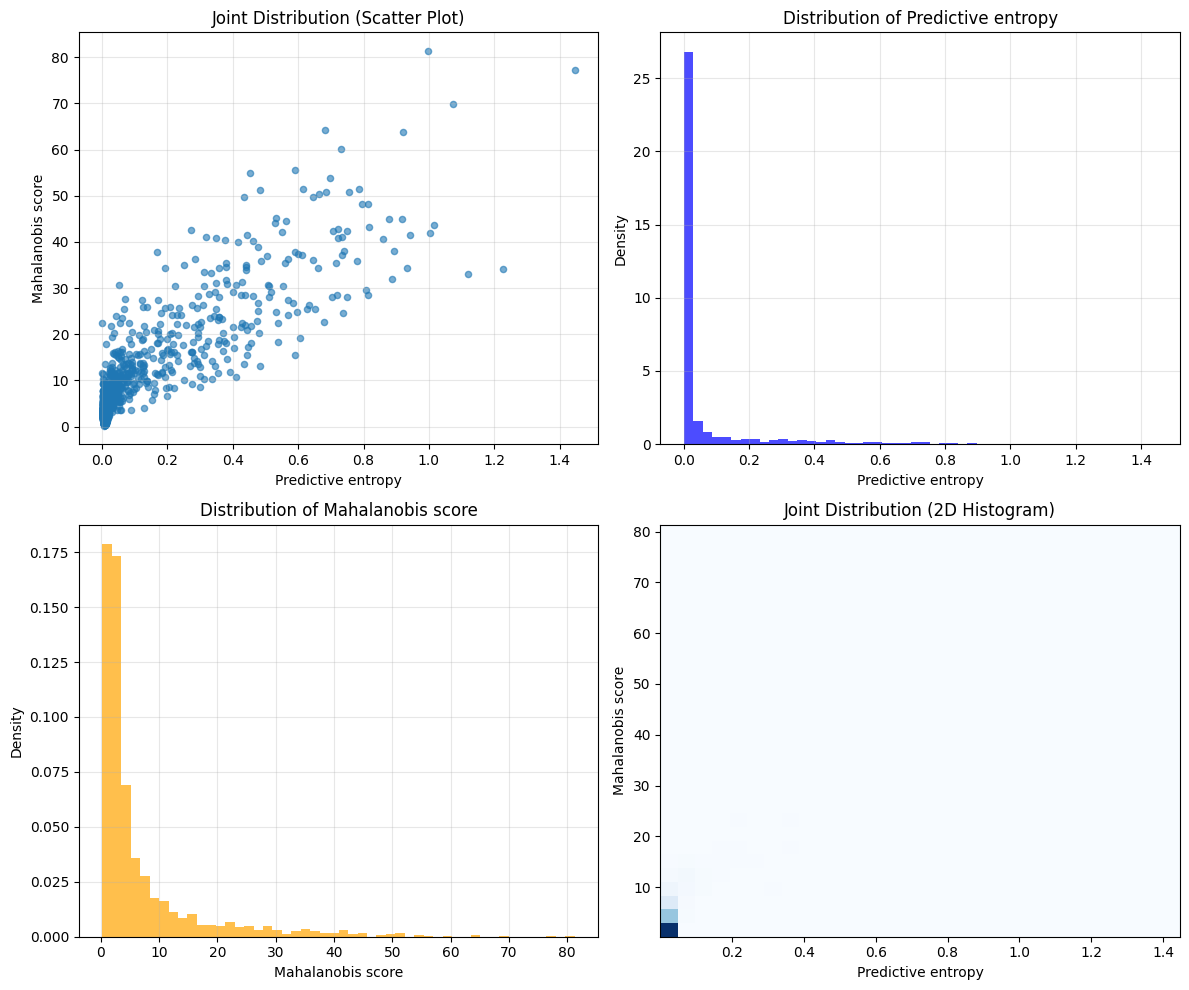

<Figure size 800x800 with 0 Axes>

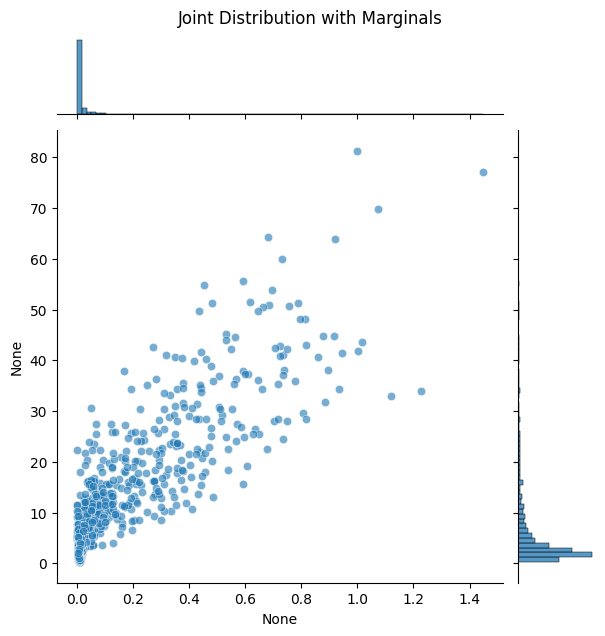

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract the two uncertainty measures
uncertainty_1 = uncertaunty_measures[:, 0]
uncertainty_2 = uncertaunty_measures[:, 1]

# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Scatter plot (joint distribution)
axes[0, 0].scatter(uncertainty_1, uncertainty_2, alpha=0.6, s=20)
axes[0, 0].set_xlabel(uncertainty_estimators[0].print_name)
axes[0, 0].set_ylabel(uncertainty_estimators[1].print_name)
axes[0, 0].set_title("Joint Distribution (Scatter Plot)")
axes[0, 0].grid(True, alpha=0.3)

# Histogram for first uncertainty measure
axes[0, 1].hist(uncertainty_1, bins=50, alpha=0.7, color="blue", density=True)
axes[0, 1].set_xlabel(uncertainty_estimators[0].print_name)
axes[0, 1].set_ylabel("Density")
axes[0, 1].set_title(f"Distribution of {uncertainty_estimators[0].print_name}")
axes[0, 1].grid(True, alpha=0.3)

# Histogram for second uncertainty measure
axes[1, 0].hist(uncertainty_2, bins=50, alpha=0.7, color="orange", density=True)
axes[1, 0].set_xlabel(uncertainty_estimators[1].print_name)
axes[1, 0].set_ylabel("Density")
axes[1, 0].set_title(f"Distribution of {uncertainty_estimators[1].print_name}")
axes[1, 0].grid(True, alpha=0.3)

# 2D histogram/density plot (joint distribution)
axes[1, 1].hist2d(uncertainty_1, uncertainty_2, bins=30, cmap="Blues")
axes[1, 1].set_xlabel(uncertainty_estimators[0].print_name)
axes[1, 1].set_ylabel(uncertainty_estimators[1].print_name)
axes[1, 1].set_title("Joint Distribution (2D Histogram)")

plt.tight_layout()
plt.show()

# Additional seaborn joint plot for better visualization
plt.figure(figsize=(8, 8))
sns.jointplot(x=uncertainty_1, y=uncertainty_2, kind="scatter", alpha=0.6)
plt.suptitle("Joint Distribution with Marginals", y=1.02)
plt.show()

In [12]:
train_kwargs = {
        "batch_size": 64,
        "device": "cpu",
    }


eot = EntropicOTOrdering(
      target='exp',
      target_params=train_kwargs,
      fit_mse_params=False,
      eps=0.25,
      n_targets=None,
      standardize=False,
      max_iters=100,
      tol=1e-6,

)  # exp, ball, beta



In [17]:
from torch.utils.data import DataLoader
import torch


train_loader = DataLoader(torch.tensor(uncertaunty_measures), batch_size=64, shuffle=True)

eot.fit(train_loader=train_loader, train_params=train_kwargs)

/home/nkotelevskii/github/multidimensional_uncertainty/.venv/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:903: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
/home/nkotelevskii/github/multidimensional_uncertainty/.venv/lib/python3.12/site-packages/ot/backend.py:1165: RuntimeWarning: overflow encountered in exp
  return np.exp(a)


In [20]:
ranks_ind, _ = eot.predict(uncertaunty_measures_ind)
ranks_ood, _ = eot.predict(uncertaunty_measures_ood)

In [23]:
from sklearn.metrics import roc_auc_score


def compute_roc_auc(ranks_ind, ranks_ood):
    ranks = np.concatenate([ranks_ind, ranks_ood])
    labels = np.concatenate([np.zeros(ranks_ind.shape[0]), np.ones(ranks_ood.shape[0])])
    return roc_auc_score(labels, ranks)

In [24]:
for name, (ind_, ood_) in [
    *[
        (
            uncertainty_estimators[i].print_name,
            (uncertaunty_measures_ind[:, i], uncertaunty_measures_ood[:, i]),
        )
        for i in range(len(uncertainty_estimators))
    ],
    ("multidimensional", (ranks_ind, ranks_ood)),
]:
    print(name, compute_roc_auc(ind_, ood_))

Predictive entropy 0.9121779861111111
Mahalanobis score 0.9090997222222222
multidimensional 0.8982424930555557


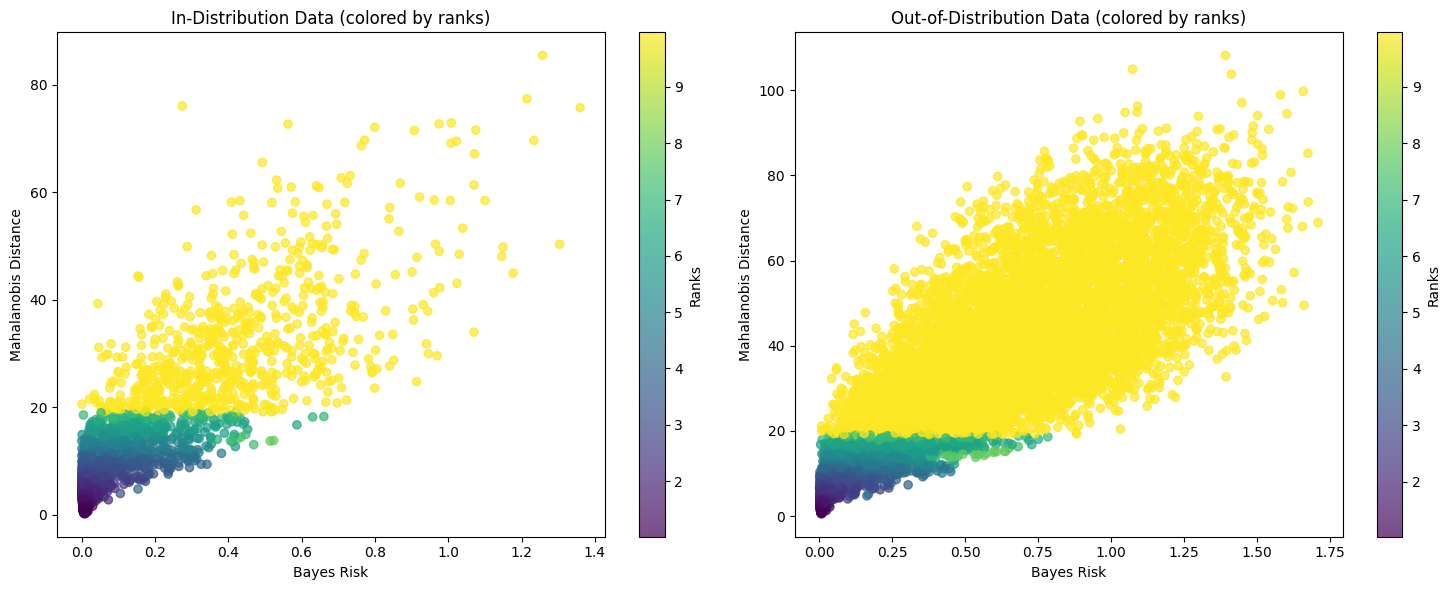

In [25]:
import matplotlib.pyplot as plt

# Create subplots for both visualizations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot for in-distribution data
scatter1 = ax1.scatter(
    uncertaunty_measures_ind[:, 0],
    uncertaunty_measures_ind[:, 1],
    c=ranks_ind,
    cmap="viridis",
    alpha=0.7,
)
ax1.set_xlabel("Bayes Risk")
ax1.set_ylabel("Mahalanobis Distance")
ax1.set_title("In-Distribution Data (colored by ranks)")
plt.colorbar(scatter1, ax=ax1, label="Ranks")

# Plot for out-of-distribution data
scatter2 = ax2.scatter(
    uncertaunty_measures_ood[:, 0],
    uncertaunty_measures_ood[:, 1],
    c=ranks_ood,
    cmap="viridis",
    alpha=0.7,
)
ax2.set_xlabel("Bayes Risk")
ax2.set_ylabel("Mahalanobis Distance")
ax2.set_title("Out-of-Distribution Data (colored by ranks)")
plt.colorbar(scatter2, ax=ax2, label="Ranks")

plt.tight_layout()
plt.show()